# Casos prácticos

En este notebook vamos a abordar dos casos prácticos interesantes.

1. Predicción (*forecasting*) de la demanda de bicicletas
2. Clasificación multiclase de imágenes

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

# 1. Predicción de la demanda de bicicletas

El problema está descrito [aquí](https://christophm.github.io/interpretable-ml-book/bike-data.html), y los datos pueden descargarse en la [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), aunque los hemos modificado un poco para hacer el problema más parecido al [*challenge*](https://www.kaggle.com/c/bike-sharing-demand/data) original.

In [3]:
data = pd.read_csv('./data/bikes.csv',sep=';', decimal='.')
data.head()

,instant,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1-1-2011,1,0,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2-1-2011,1,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,3-1-2011,1,0,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,4-1-2011,1,0,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,5-1-2011,1,0,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


<div class = "alert alert-success">
**EJERCICIO**: Interpreta los datos y realiza tus primeras hipótesis sobre qué variables son de interés
</div>

<div class = "alert alert-success">
**EJERCICIO**: Elimina las columnas *instant*, *casual* y *registered*
</div>

In [4]:
# your code here
data.dtypes

instant         int64
dteday         object
season          int64
holiday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [5]:
data.shape

(731, 13)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896
hum,731.0,0.627894,0.142429,0.000000,0.520000,0.626667,0.730209,0.972500
windspeed,731.0,0.190486,0.077498,0.022392,0.134950,0.180975,0.233214,0.507463
casual,731.0,848.176471,686.622488,2.000000,315.500000,713.000000,1096.000000,3410.000000


In [7]:
data.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)

In [8]:
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1-1-2011,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2-1-2011,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,3-1-2011,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,4-1-2011,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,5-1-2011,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [9]:
data.isnull().any()

dteday        False
season        False
holiday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
cnt           False
dtype: bool

#### NOTA IMPORTANTE: 

Todos los datasets que hemos usado están preprocesados mínimamente: no hay valores ausentes, pocos outliers... en la realidad y en la práctica final no va a ser así. El tratamiento de outliers es un poco artesanal: se puede hacer con un filtro, por ejemplo, como ya hemos visto, o analizando manualmente los scatter plots. 

Para los valores ausentes, hay que imputar. Es muy sencillo con pandas, usando ``fillna``:

``df["Feature"].fillna(df["Feature"].mode()[0], inplace=True)``

El caso de arriba rellena con la moda (valor más frecuente), en otras ocasiones es preferible usar la media, y en algunos (pocos) casos se puede hacer con ceros.

## 1.1 *Feature Engineering*

Vamos a trabajar con las fechas para crear algunas variables auxiliares

In [10]:
from datetime import datetime

data['dteday'] = data['dteday'].apply(lambda x: datetime.strptime(x,'%d-%m-%Y'))
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [11]:
data.dtypes

dteday        datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
dtype: object

In [12]:
data['year'] = data['dteday'].apply(lambda x: x.year - 2011)
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


In [13]:
data['year'].value_counts()

1    366
0    365
Name: year, dtype: int64

In [14]:
data['month'] = data['dteday'].apply(lambda x: x.month)
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0,1
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0,1
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,1
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,1


In [15]:
data['weekday'] = data['dteday'].apply(lambda x: x.isoweekday())
data.head()

,dteday,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,weekday
0,2011-01-01,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0,1,6
1,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0,1,7
2,2011-01-03,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1,1
3,2011-01-04,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,1,2
4,2011-01-05,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,1,3


Llegados a este punto, podemos eliminar la variable *dteday*

In [16]:
data = data.drop(['dteday'],axis=1)
data.head()

,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,weekday
0,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,0,1,6
1,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0,1,7
2,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1,1
3,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,1,2
4,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,1,3


In [17]:
data.dtypes

season          int64
holiday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
year            int64
month           int64
weekday         int64
dtype: object

## 1.2 Análisis de correlación

<div class = "alert alert-success">
**EJERCICIO**: Represente la variable *temp* vs *atemp*.
</div>

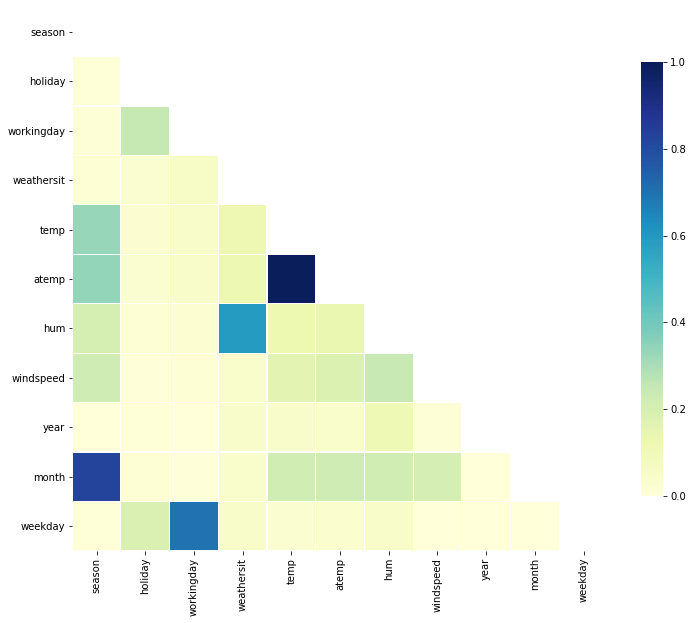

In [18]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['cnt'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

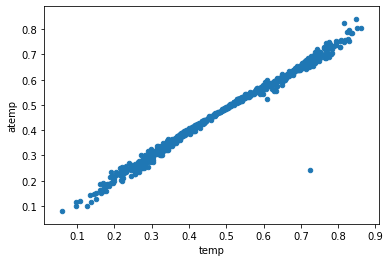

In [19]:
# your code here
data.plot(kind = 'scatter',x='temp',y = 'atemp')
plt.xlabel('temp')
plt.ylabel('atemp')
plt.show()

A la vista está que son variables altamente correlacionadas. Podemos eliminar *temp*, ya que nos afecta más la sensación térmica que la temperatura real (también podríamos eliminar atemp)

In [20]:
data = data.drop(['temp'],axis=1)
data.head()

,season,holiday,workingday,weathersit,atemp,hum,windspeed,cnt,year,month,weekday
0,1,0,0,2,0.363625,0.805833,0.160446,985,0,1,6
1,1,0,0,2,0.353739,0.696087,0.248539,801,0,1,7
2,1,0,1,1,0.189405,0.437273,0.248309,1349,0,1,1
3,1,0,1,1,0.212122,0.590435,0.160296,1562,0,1,2
4,1,0,1,1,0.229270,0.436957,0.186900,1600,0,1,3


<div class = "alert alert-success">
**EJERCICIO**(@home): Realice un análisis exploratorio exhaustivo.
</div>

# 1.3 Codificación de variables categóricas

Tenemos varias variables categóricas: *season*, *weathersit*, *month* y *weekday*. Cuando trabajamos con series temporales, es común crear variables *dummies* asociadas a cada una de las situaciones de las variables categóricas. Para ello, tenemos dos opciones:

- [pd.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html): se aplica directamente sobre el dataframe puede [utilizarse](https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40) con strings directamente. La pega es que genera un nuevo dataframe que hay que agregar al original.
- [MeanEncoder](https://maxhalford.github.io/blog/target-encoding/): no está implementado (que yo sepa) en scikit learn pero mola tanto que da igual. Asigna un valor a cada variable categórica según la media de la columna objetivo para el conjunto de registros que tienen esa variable categórica. Es decir, si quisiera categorizar la variable "Barrio" con un ME, lo que tendría que hacer es calcular la media de precio en cada barrio (Villaverde, Chamberí, etc) y sustituir el nombre del barrio por esa media. Ojito con el data leakage, os dejo un ejemplo debajo de cómo hacerlo bien.

Tutoriales sobre codificación de variables categóricas: [Tutorial 1](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c), [tutorial 2](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)

La codificación "dummy" de variables categóricas en problemas de clasificación/regresión es opcional, como vimos anteriormente, pero en series temporales resulta adecuado para explicar el efecto de una situación temporal en la variable target.

Vamos a utilizar los dos métodos para codificar las variables categóricas.  

<div class = "alert alert-success">
**EJERCICIO**(@home): Prueba no realizar esta codificación "dummy" y entrena un modelo de machine learning para predecir la demanda de bicicletas.
</div>

Comenzamos por la variable *season*. Veamos qué hace *get_dummies()*.

In [21]:
pd.get_dummies(data['season'], prefix = 'season')

,season_1,season_2,season_3,season_4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
726,1,0,0,0
727,1,0,0,0
728,1,0,0,0
729,1,0,0,0


In [22]:
dummy = pd.get_dummies(data['season'], prefix = 'season')

data = pd.concat([data,dummy],axis=1).drop(['season'],axis=1)
data.head()

,holiday,workingday,weathersit,atemp,hum,windspeed,cnt,year,month,weekday,season_1,season_2,season_3,season_4
0,0,0,2,0.363625,0.805833,0.160446,985,0,1,6,1,0,0,0
1,0,0,2,0.353739,0.696087,0.248539,801,0,1,7,1,0,0,0
2,0,1,1,0.189405,0.437273,0.248309,1349,0,1,1,1,0,0,0
3,0,1,1,0.212122,0.590435,0.160296,1562,0,1,2,1,0,0,0
4,0,1,1,0.229270,0.436957,0.186900,1600,0,1,3,1,0,0,0


In [23]:
categorical = ['weathersit', 'month', 'weekday']

mean_map = {}
for c in categorical:
    mean = data.groupby(c)['cnt'].mean()
    data[c] = data[c].map(mean)    
    mean_map[c] = mean

# Si hubiera test, luego se haría:
#for c in categorical:
#    data_test[c] = data_test[c].map(mean_map[c])

data.head()

,holiday,workingday,weathersit,atemp,hum,windspeed,cnt,year,month,weekday,season_1,season_2,season_3,season_4
0,0,0,4035.862348,0.363625,0.805833,0.160446,985,0,2176.33871,4550.542857,1,0,0,0
1,0,0,4035.862348,0.353739,0.696087,0.248539,801,0,2176.33871,4228.828571,1,0,0,0
2,0,1,4876.786177,0.189405,0.437273,0.248309,1349,0,2176.33871,4338.123810,1,0,0,0
3,0,1,4876.786177,0.212122,0.590435,0.160296,1562,0,2176.33871,4510.663462,1,0,0,0
4,0,1,4876.786177,0.229270,0.436957,0.186900,1600,0,2176.33871,4548.538462,1,0,0,0


Este es uno de los tutoriales más completos que he visto: [Encoding done the right way](https://maxhalford.github.io/blog/target-encoding/) y me hace especial gracia porque dice esto: "Label encoding is useless and you should never use it". No estoy 100% de acuerdo obviamente :) pero sí que es cierto que cuando hay muchas categorías (es decir, no es binario) un LE puede llevar a errores porque asigna números a cada una de ellas, con lo cual el algoritmo puede "aprender" erróneamente. Supongamos que tengo una categoría barrio que quiero categorizar:

- Barrio céntrico moderno y caro -> LE -> 1
- Otro barrio -> LE -> 2
- Otro más -> LE -> 3
- Y otro -> LE -> 4
- Barrio periférico y obrero -> LE -> 5

Mis categorías tras el LE pasarían a ser 1-5, pero qué quiere decir esto? Que 5 es mayor que 1? Que 3 es menor que 5? No, porque no existe esa relación entre los barrios, pero SÍ entre los números! Entonces el algoritmo podría decidir que de alguna manera "Barrio periférico y obrero > Barrio céntrico moderno y caro" porque 5 > 1.

## 1.4 División train/test 

In [24]:
# preparamos los datos
features = data.columns.drop(['cnt'])
X = data[features].values
y = data['cnt'].values

print('Filas, columnas', X.shape)

Filas, columnas (731, 13)


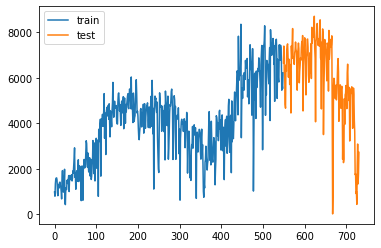

In [25]:
# Paso 1:
offset = 182 # 0.25 of 731

X_train = X[:-offset, :]
y_train = y[:-offset]
X_test  = X[-offset:, :]
y_test  = y[-offset:]

plt.plot(range(0,len(y_train)),y_train, label='train')
plt.plot(range(len(y_train),len(y)),y_test,label='test')
plt.legend()
plt.show()

## 1.5 Búsqueda de parámetros libres

In [26]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Lasso

tscv = TimeSeriesSplit(n_splits=3)

alpha_vector = np.logspace(-5,3,25)
param_grid = {'alpha': alpha_vector}

grid = GridSearchCV(Lasso(), param_grid=param_grid, cv = tscv.split(X_train)).fit(X_train, y_train)

best mean cross-validation score: 0.088
best parameters: {'alpha': 1e-05}


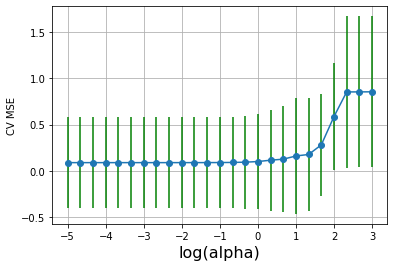

In [27]:
print("best mean cross-validation score: {:.3f}".format(-1*grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(alpha_vector),-1*scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(alpha)',fontsize=16)
plt.ylabel('CV MSE')
plt.grid()
plt.show()

## 1.6 Métricas en test

In [28]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X_train,y_train)

ytrainLasso = lasso.predict(X_train)
ytestLasso  = lasso.predict(X_test)

mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_

for f,wi in zip(features,w):
    print(f,wi)

MSE Modelo Lasso (train): 4.54e+05
MSE Modelo Lasso (test) : 1.21e+06
RMSE Modelo Lasso (train): 674
RMSE Modelo Lasso (test) : 1.1e+03
holiday -456.8952568797472
workingday -68.69074606723413
weathersit 0.5413200906505362
atemp 3963.2518259756334
hum -1169.086043521014
windspeed -2367.0628344059737
year 2000.5509520995522
month 0.3611053841644154
weekday 0.7129166547785326
season_1 -631.8746343598673
season_2 22.07081363315303
season_3 -410.282939047033
season_4 359.18617377518706


<div class = "alert alert-success">
**EJERCICIO**: Representa la predicción obtenida junto con la serie real (train+test)
</div>

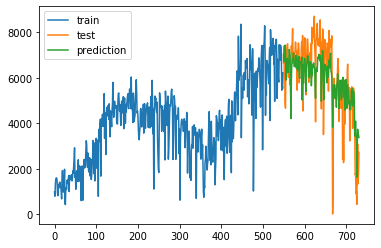

In [29]:
# your code here
plt.plot(range(0,len(y_train)),y_train, label='train')
plt.plot(range(len(y_train),len(y)),y_test,label='test')
plt.plot(range(len(y_train),len(y)),ytestLasso,label='prediction')
plt.legend()
plt.show()

# 2. Clasificación multiclase de imágenes

En este caso vamos a utilizar la famosa base de datos de [MNIST](http://yann.lecun.com/exdb/mnist/). Esta base de datos contiene

* Training set: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 samples)
* Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
* Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 samples)
* Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

Estas imágenes se pueden descargar a partir del siguiente código (previamente hay que descargarse los archivos).

In [30]:
import os
import struct
import numpy as np
import gzip
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte.gz' % kind)
        
    with gzip.open(labels_path, 'rb') as lbpath:
        lbpath.read(8)
        buffer = lbpath.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        imgpath.read(16)
        buffer = imgpath.read()
        images = np.frombuffer(buffer, 
                               dtype=np.uint8).reshape(
            len(labels), 784).astype(np.float64)
 
    return images, labels

In [31]:
# Esto os va a fallar si no lo tenéis bajado; da igual

#X_train, y_train = load_mnist('./data/mnist/', kind='train')
#print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

In [32]:
#X_test, y_test = load_mnist('mnist/', kind='t10k')
#print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

No obstante, sklearn tiene la base de datos incluida en sus datasets.

In [33]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

# rescale the data, use the traditional train/test split
X, y = mnist.data / 255., mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

¡Fíjate que el conjunto de entrenamiento son los pixels de la imagen tal cual!

In [34]:
print ("X train shape: ", X_train.shape)
print ("y train shape: ", y_train.shape)
print ("X test shape: ",  X_test.shape)
print ("y test shape: ", y_test.shape)

X train shape:  (60000, 784)
y train shape:  (60000,)
X test shape:  (10000, 784)
y test shape:  (10000,)


Representamos algunos ejemplos:

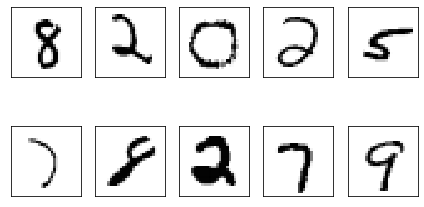

In [35]:
randomIds = np.random.randint(0,60000,10)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i,n in enumerate(randomIds):
    img = X_train[n,:].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

<div class = "alert alert-success">
**EJERCICIO**: Entrena un modelo de regresión logística con C = 10 y calcula sus prestaciones en el conjunto de test. A lo mejor te resulta de utilidad revisar la [documentación](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
</div>

In [36]:
from sklearn.linear_model import LogisticRegression

# your code here
lr = LogisticRegression(C=10, multi_class='multinomial').fit(X_train, y_train)

<div class = "alert alert-success">
**EJERCICIO**: Calcula y representa la matriz de confusión, ¿qué conclusiones puedes sacar?
</div>

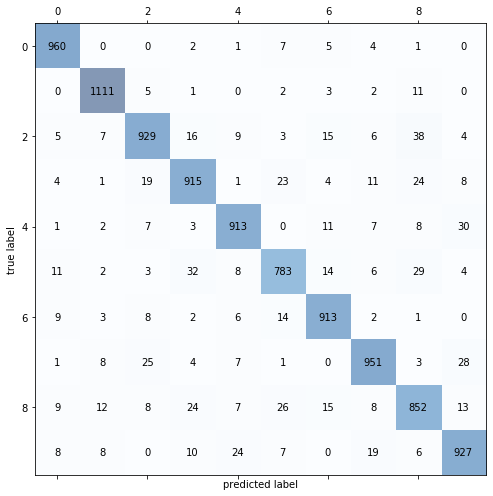

In [37]:
from sklearn.metrics import confusion_matrix

# your code here
y_pred = lr.predict(X_test)
confmat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(confmat)

# Pequeña ayuda para la práctica final

El método ``train_test_split`` es mucho más potente que lo que hemos visto en clase, y permite hacer muchas más cosas. En clase siempre hemos particionado en cuatro (xtrain, xtest, ytrain, ytest) obteniendo arrays de numpy, pero no es la única opción. Aquí tenéis un único fichero .csv, y podéis usar la función para obtener dos subconjuntos: train y test.

In [ ]:
from sklearn.model_selection import train_test_split

full_df = pd.read_csv('./airbnb-listings-extract.csv', sep=';', decimal='.')
train, test = train_test_split(full_df, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df = pd.read_csv('./train.csv', sep=';', decimal='.')

# etc...

A la hora de dividir en ``X`` e ``y`` lo que tendréis que hacer es algo como esto:

In [ ]:
from sklearn import preprocessing
data = df.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = df.columns[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

Y cuando queráis ya evaluar el modelo (después de hacer CV y demás) tendréis que cargar el csv de test:

In [ ]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# aplicarle LAS MISMAS transformaciones que hayáis hecho en train 
#(drop de columnas, filtros, generaciones, fill...) y sacar los datos:

data_test = df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 